In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LSTM1 - 일별/읍면동별 단순 시계열 예측
* https://roboreport.co.kr/%eb%94%a5%eb%9f%ac%eb%8b%9dlstm%ec%9c%bc%eb%a1%9c-%ec%95%84%ed%8c%8c%ed%8a%b8-%ec%a7%80%ec%88%98-%ec%98%88%ec%b8%a1%ed%95%98%ea%b8%b0-2-lstm-%ec%8b%a4%ed%97%98%ed%95%98%ea%b8%b0/
* https://ichi.pro/ko/yecheug-bunseog-tensorfloweseo-gru-mich-bilstmeul-sayonghan-sigyeyeol-yecheug-148814384408853


In [53]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [54]:
# df1 = pd.read_csv('/content/drive/MyDrive/BigCon/01_음식물쓰레기_FOOD_WASTE.CSV.csv', encoding='cp949')
# df1.head()

In [55]:
# 음쓰 데이터 불러오기 by 시계열
음쓰 = pd.read_csv('/content/drive/MyDrive/BigCon/01_음식물쓰레기_FOOD_WASTE.CSV.csv', parse_dates=['base_date'], index_col='base_date', encoding='cp949')
음쓰 = 음쓰[['emd_nm', 'em_g']]
음쓰.head()

,emd_nm,em_g
base_date,,
2018-01-01,외도동,15500
2018-01-01,이도2동,64650
2018-01-01,아라동,33500
2018-01-01,삼양동,8400
2018-01-01,이도2동,51450


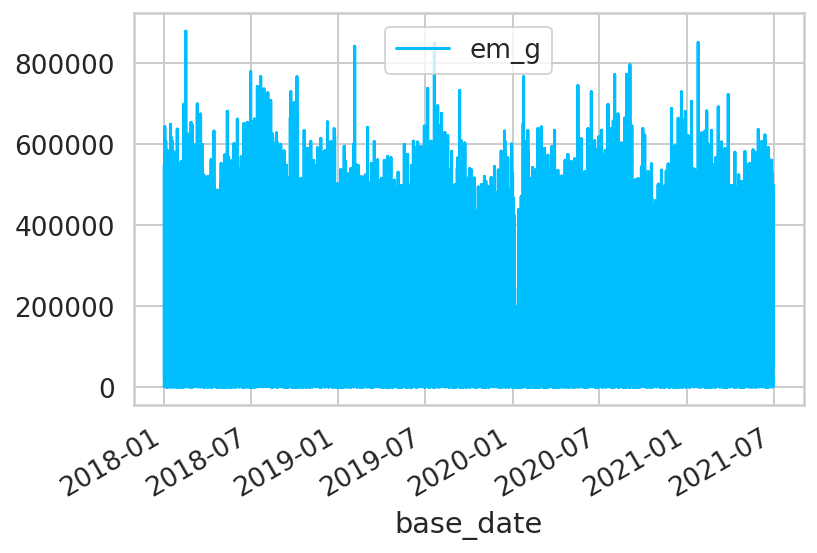

In [56]:
# 예시: 외도동
외도동 = 음쓰[음쓰['emd_nm']=='외도동']
외도동.plot()

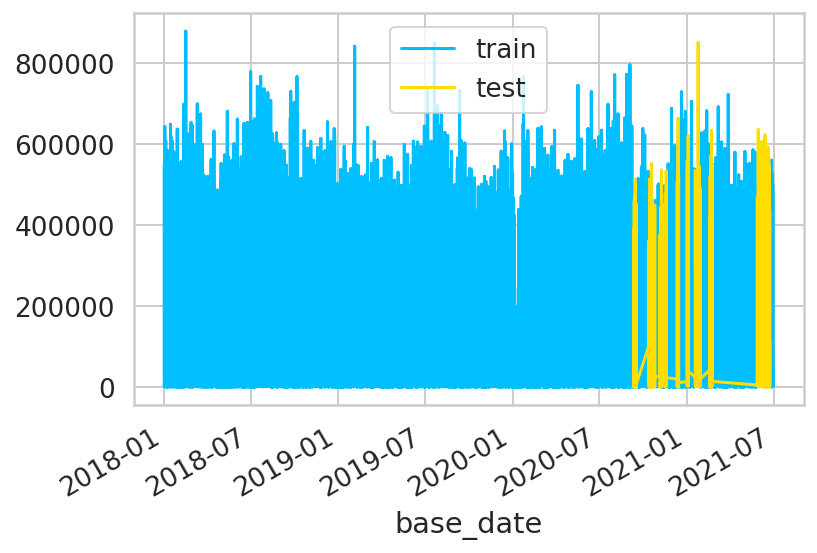

In [57]:
# 학습데이터/테스트데이터 분리 - 기준: 2021-01-01
split_date = pd.Timestamp('2021-01-01')

train = 외도동.loc[:split_date, ['em_g']]
test = 외도동.loc[split_date:, ['em_g']]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [58]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [59]:
train_sc_df = pd.DataFrame(train_sc, columns=['em_g'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['em_g'], index=test.index)
train_sc_df.head()

,em_g
base_date,
2018-01-01,0.017669
2018-01-01,0.001425
2018-01-01,0.026389
2018-01-01,0.010088
2018-01-01,0.022457


In [60]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['em_g'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['em_g'].shift(s)

train_sc_df.head(13)

,em_g,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
base_date,,,,,,,,,,,,,
2018-01-01,0.017669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.001425,0.017669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.026389,0.001425,0.017669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.010088,0.026389,0.001425,0.017669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.022457,0.010088,0.026389,0.001425,0.017669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.009404,0.022457,0.010088,0.026389,0.001425,0.017669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.140268,0.009404,0.022457,0.010088,0.026389,0.001425,0.017669,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.169678,0.140268,0.009404,0.022457,0.010088,0.026389,0.001425,0.017669,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.095013,0.169678,0.140268,0.009404,0.022457,0.010088,0.026389,0.001425,0.017669,NaN,NaN,NaN,NaN


In [61]:
X_train = train_sc_df.dropna().drop('em_g', axis=1)
y_train = train_sc_df.dropna()[['em_g']]

X_test = test_sc_df.dropna().drop('em_g', axis=1)
y_test = test_sc_df.dropna()[['em_g']]

X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
base_date,,,,,,,,,,,,
2018-01-01,0.100655,0.131490,0.162154,0.095013,0.169678,0.140268,0.009404,0.022457,0.010088,0.026389,0.001425,0.017669
2018-01-01,0.025477,0.100655,0.131490,0.162154,0.095013,0.169678,0.140268,0.009404,0.022457,0.010088,0.026389,0.001425
2018-01-01,0.098547,0.025477,0.100655,0.131490,0.162154,0.095013,0.169678,0.140268,0.009404,0.022457,0.010088,0.026389
2018-01-01,0.015959,0.098547,0.025477,0.100655,0.131490,0.162154,0.095013,0.169678,0.140268,0.009404,0.022457,0.010088
2018-01-01,0.018011,0.015959,0.098547,0.025477,0.100655,0.131490,0.162154,0.095013,0.169678,0.140268,0.009404,0.022457


In [62]:
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values
print(X_train.shape)
#print(X_train)
print(y_train.shape)
#print(y_train)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(74043, 12)
(74043, 1)


In [63]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(74043, 12, 1)
[[[0.10065546]
  [0.13149045]
  [0.16215446]
  ...
  [0.02638928]
  [0.00142491]
  [0.01766885]]

 [[0.02547734]
  [0.10065546]
  [0.13149045]
  ...
  [0.01008834]
  [0.02638928]
  [0.00142491]]

 [[0.09854659]
  [0.02547734]
  [0.10065546]
  ...
  [0.02245654]
  [0.01008834]
  [0.02638928]]

 ...

 [[0.0492448 ]
  [0.63482474]
  [0.4107723 ]
  ...
  [0.01527501]
  [0.01037333]
  [0.04274722]]

 [[0.04320319]
  [0.0492448 ]
  [0.63482474]
  ...
  [0.02177258]
  [0.01527501]
  [0.01037333]]

 [[0.01983471]
  [0.04320319]
  [0.0492448 ]
  ...
  [0.03807353]
  [0.02177258]
  [0.01527501]]]
[[0.02547734]
 [0.09854659]
 [0.01595896]
 ...
 [0.04320319]
 [0.01983471]
 [0.00547164]]


In [64]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

K.clear_session()

# 모델은 확정되면 튜닝    
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [65]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100,
          batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/100
2469/2469 [==============================] - 10s 3ms/step - loss: 0.0041
Epoch 2/100
2469/2469 [==============================] - 8s 3ms/step - loss: 0.0030
Epoch 3/100
2469/2469 [==============================] - 8s 3ms/step - loss: 0.0028
Epoch 4/100
2469/2469 [==============================] - 8s 3ms/step - loss: 0.0028
Epoch 5/100
2469/2469 [==============================] - 8s 3ms/step - loss: 0.0026
Epoch 6/100
2469/2469 [==============================] - 8s 3ms/step - loss: 0.0024
Epoch 7/100
2469/2469 [==============================] - 8s 3ms/step - loss: 0.0022
Epoch 8/100
2469/2469 [==============================] - 8s 3ms/step - loss: 0.0021
Epoch 9/100
2469/2469 [==============================] - 8s 3ms/step - loss: 0.0019
Epoch 10/100
2469/2469 [==============================] - 8s 3ms/step - loss: 0.0019
Epoch 11/100
2469/2469 [==============================] - 8s 3ms/step - loss: 0.0018
Epoch 12/100
2469/2469 [==============================] - 8s 3ms/step - l

In [66]:
print(X_test_t)

[[[0.10891992]
  [0.08161869]
  [0.08253064]
  ...
  [0.03944144]
  [0.01350812]
  [0.01612995]]

 [[0.11427757]
  [0.10891992]
  [0.08161869]
  ...
  [0.0108293 ]
  [0.03944144]
  [0.01350812]]

 [[0.02838416]
  [0.11427757]
  [0.10891992]
  ...
  [0.01709889]
  [0.0108293 ]
  [0.03944144]]

 ...

 [[0.030778  ]
  [0.59874608]
  [0.27016244]
  ...
  [0.01932174]
  [0.03174694]
  [0.00786549]]

 [[0.05249359]
  [0.030778  ]
  [0.59874608]
  ...
  [0.04964377]
  [0.01932174]
  [0.03174694]]

 [[0.01595896]
  [0.05249359]
  [0.030778  ]
  ...
  [0.03123397]
  [0.04964377]
  [0.01932174]]]


Text(0, 0.5, 'Predicted Index: $\\hat{Y}_i$')

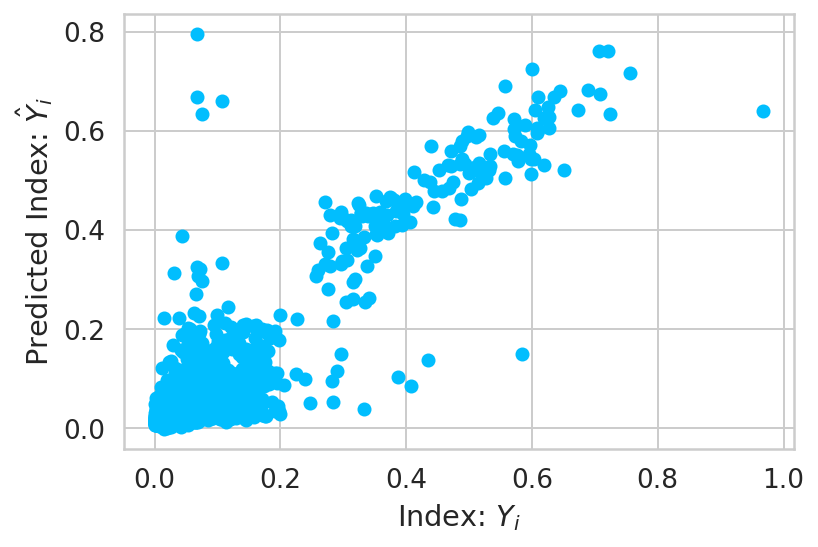

In [67]:
# 원래 값과 예측 값이 일치하면 직선에 가깝게 분포 -> 그나마 잘 예측된 듯

%matplotlib inline
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Index: $Y_i$")
plt.ylabel("Predicted Index: $\hat{Y}_i$")

# LSTM2 - 월별/읍면동별 다변량 시계열 예측 - 쓰레기
* https://data-panic.tistory.com/33 

In [4]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [5]:
# 추후 거주인구 + 카드 + 기타 변수 추가 필요
df = pd.read_csv("/content/drive/MyDrive/BigCon/0815음쓰-외국인데이터병합.csv")
df.head()

,base_date,emd_nm,em_cnt,em_g,pay_amt,resd_sum,idx_resd,work_sum,idx_work,visit_sum,idx_visit,visit_sum_short,idx_visit_short
0,2018-01-01,건입동,668,1708250,51079,4474.9713,1.0,797.8143,2.0,4778.0214,1.0,4777.1626,2.0
1,2018-01-01,남원읍,304,1239600,37110,6950.7046,0.0,1021.6273,2.0,2195.4912,1.0,3552.3268,2.0
2,2018-01-01,노형동,3903,9357900,278317,43922.5457,0.0,3131.9551,2.0,11470.8559,2.0,9654.0358,0.0
3,2018-01-01,대륜동,650,1717700,50076,2955.7580,2.0,215.7699,1.0,2710.6033,2.0,1347.0481,2.0
4,2018-01-01,대정읍,309,1264950,37872,22313.3840,0.0,626.1784,2.0,5217.9039,1.0,1988.0280,2.0


In [6]:
# 필요 없는 칼럼 제거 -> 읍면동별은 나중에 
df = df[['base_date', 'em_g', 'resd_sum', 'work_sum', 'visit_sum', 'visit_sum_short']] # sum
#df = df[['base_date', 'em_g', 'idx_resd_sum', 'idx_work_sum', 'idx_visit_sum', 'idx_visit_sum_short']] # idx

## Lag 변수 생성

In [7]:
df.base_date = pd.to_datetime(df.base_date)
df.set_index('base_date', inplace=True)

In [8]:
lag_col= list(df.columns)

In [9]:
# 모든 변수에 대해 시차 변수 생성
# 일단은 3개의 시차 - na는 날려주기
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
    
df.dropna(inplace=True)

## Data Exploration

In [10]:
# 결측치 확인
df.isnull().sum().sum()

0

In [11]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['em_g'].shape))

전체 데이터 shape: (42550, 20)
target feature shape: (42550,)


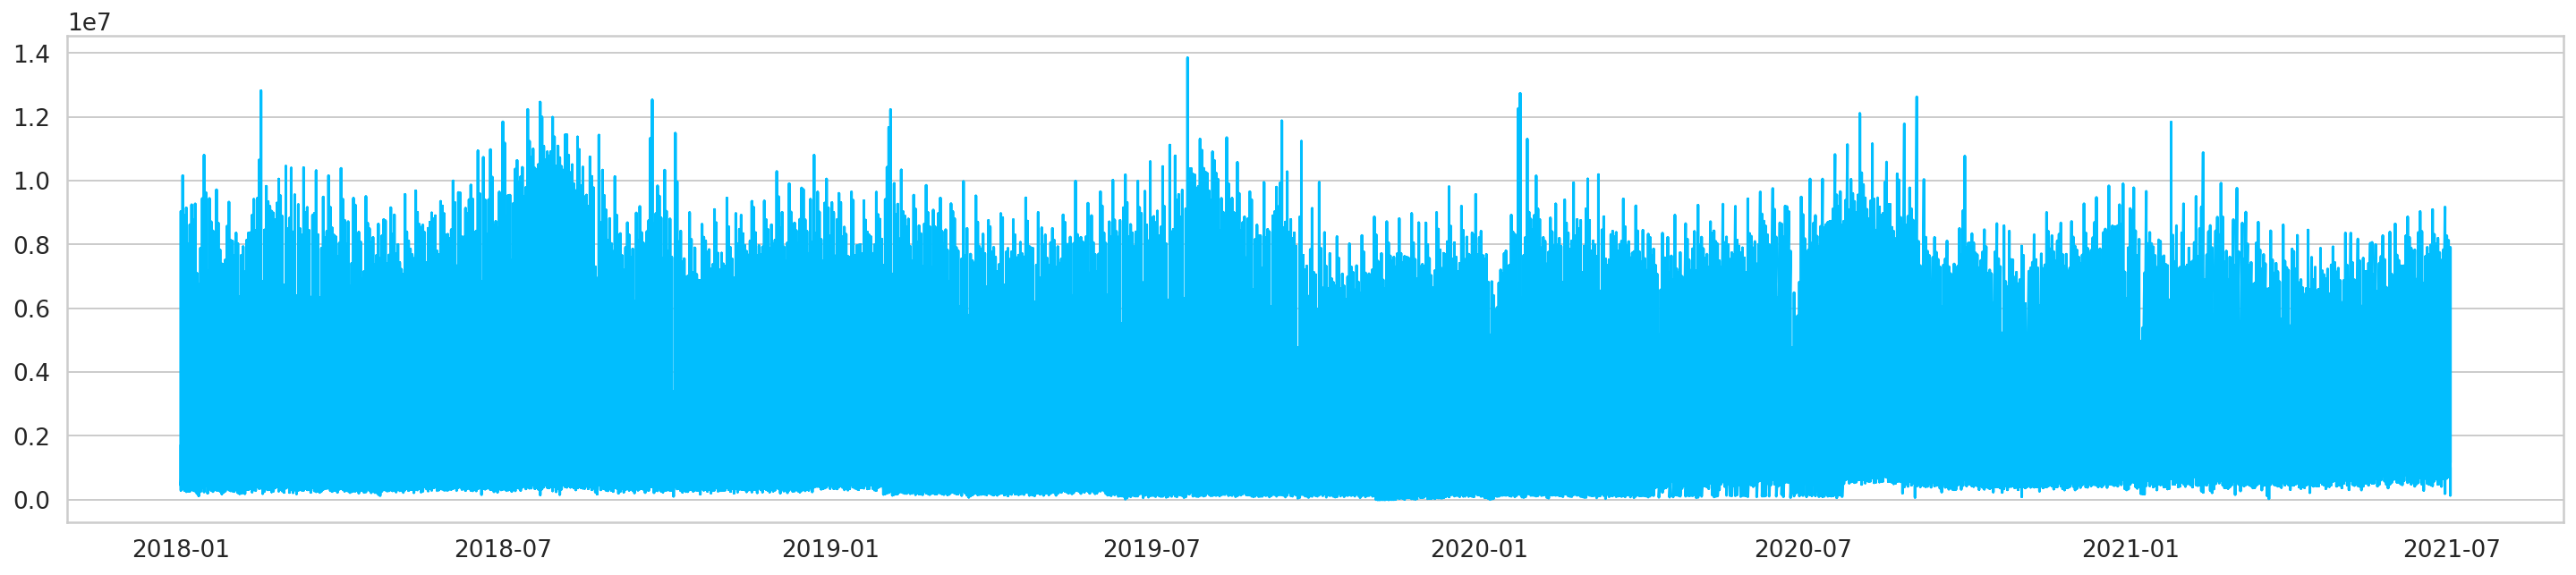

In [12]:
# 제주 전체 음쓰 일별 시각화
plt.figure(figsize=(25,5))
plt.plot(df['em_g'])
plt.grid(axis='x')

## LSTM Model

In [13]:
X_cols = list(df.columns)
X_cols.remove('em_g')

In [14]:
# 테스트 데이터 수
test_data_size = 10638 # 42550*0.25

# X변수들과 y변수 구분
X = df[X_cols]
y = df['em_g']

In [15]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [16]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (31912, 19)
test set :  (10638, 19)


In [17]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return res

In [18]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [19]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [20]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([31912, 1, 19])
X_test : torch.Size([10638, 1, 19])
y_train : torch.Size([31912, 1])
y_test : torch.Size([10638, 1])


## Building a Model

In [21]:
# Model Class 생성

class Predictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(Predictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## Training

In [22]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [23]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=10

In [24]:
# Training Model
model = Predictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.0235 test loss: 0.0193


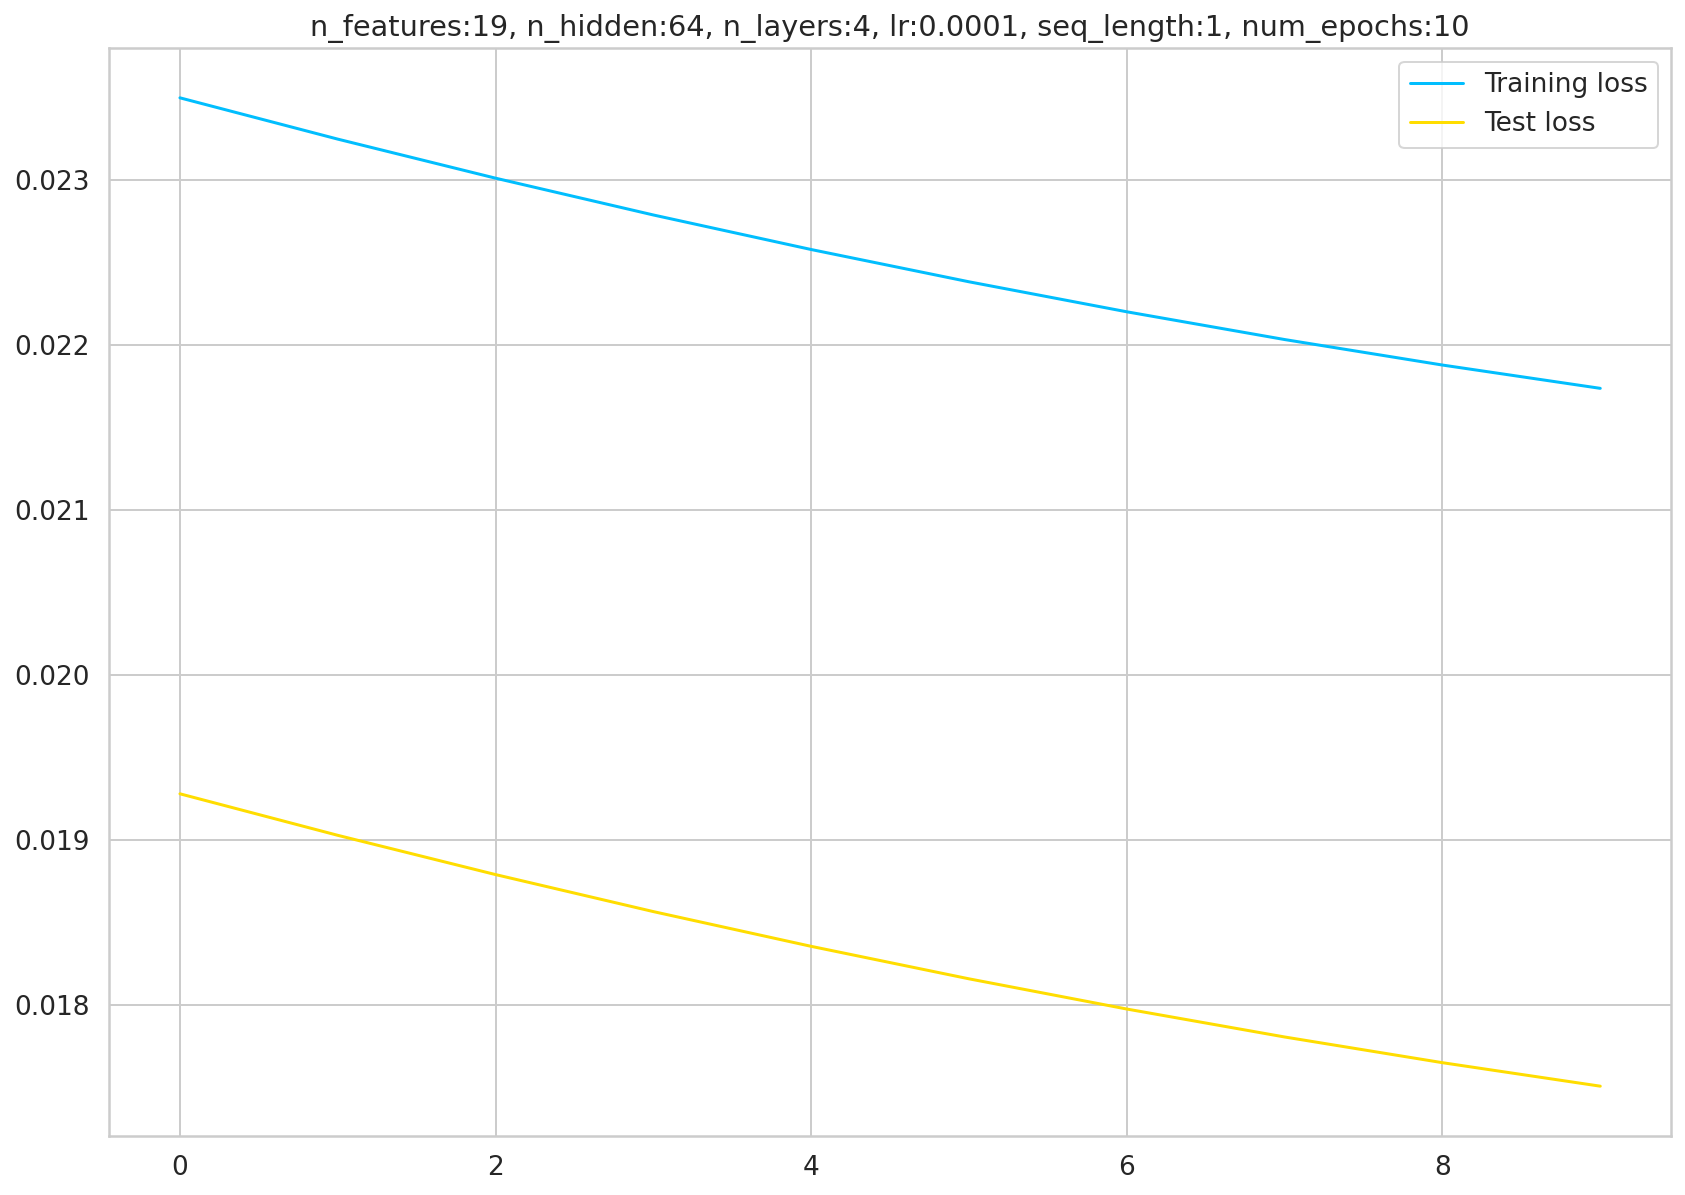

In [25]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

## Predicting daily cases

In [ ]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

preds

In [27]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))
pred_values

array([[1743620.16624957],
       [1750059.62460861],
       [1753989.88696933],
       ...,
       [1760604.2711921 ],
       [1760638.51375505],
       [1760528.97880971]])

In [30]:
pred_values_ceiled  = list(pred_values.flatten())

In [31]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [32]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [34]:
score_table
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))
score_table

,True,Pred
0,3.975150e+06,1.743620e+06
1,7.794400e+06,1.750060e+06
2,1.219850e+06,1.753990e+06
3,2.351050e+06,1.756225e+06
4,1.282000e+06,1.757611e+06
...,...,...
10633,1.377450e+06,1.760364e+06
10634,9.738500e+05,1.760500e+06
10635,3.298100e+06,1.760604e+06
10636,3.749600e+06,1.760639e+06


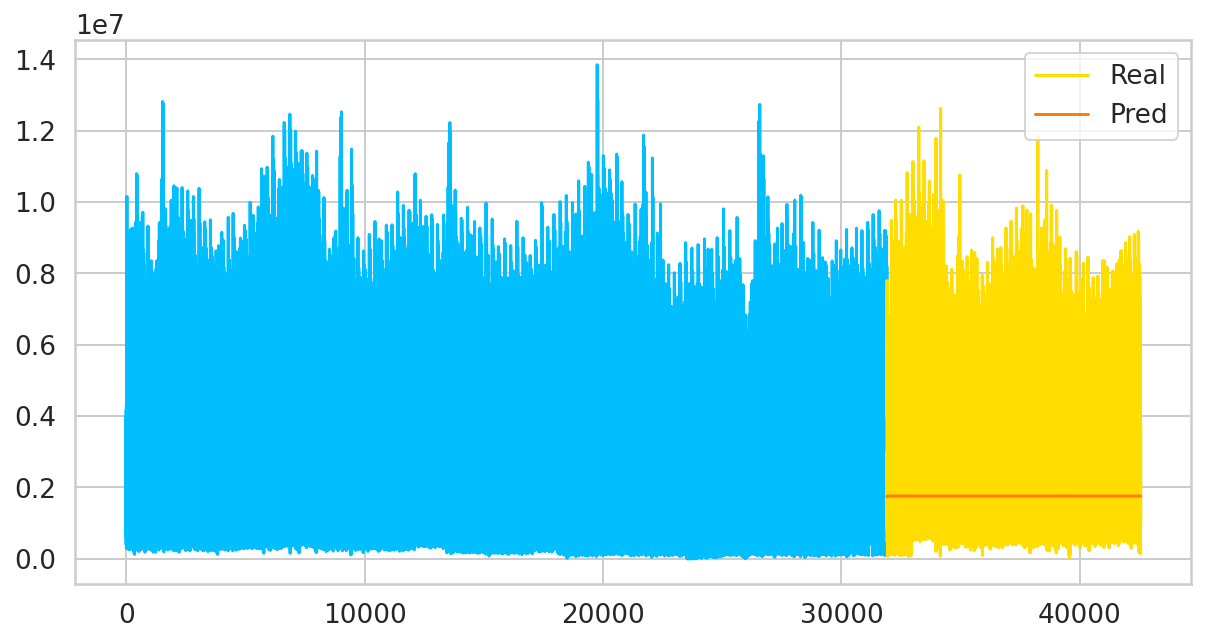

In [35]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [37]:
# # 모델 저장
# #PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
# PATH = './models/{6}_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs, score.round(2))

# torch.save(model, PATH)

In [38]:
# # 모델 불러오기
# #PATH = './models/score84_n_features_10_n_hidden_64_n_layers_4_lr_0.0001_seq_length_1_num_epochs_250.pth'
# model = torch.load(PATH)
# #model.eval()

## Use all data for training 

In [39]:
# X변수들과 y변수 구분
X_all = df[X_cols]
y_all = df['em_g']

In [40]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [41]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (42550, 19)
y_all :  (42550,)


In [42]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

## Predicting future cases

In [43]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [44]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [45]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[1760301.8639795482,
 1760096.4086018503,
 1759995.7437179983,
 1760008.9456699789,
 1760105.2786633372,
 1760244.1054396331,
 1760393.2462409139,
 1760532.4855782092,
 1760651.5094265342,
 1760748.254980892,
 1760824.1662047803,
 1760882.3373056948,
 1760926.2750521302,
 1760959.073651582]

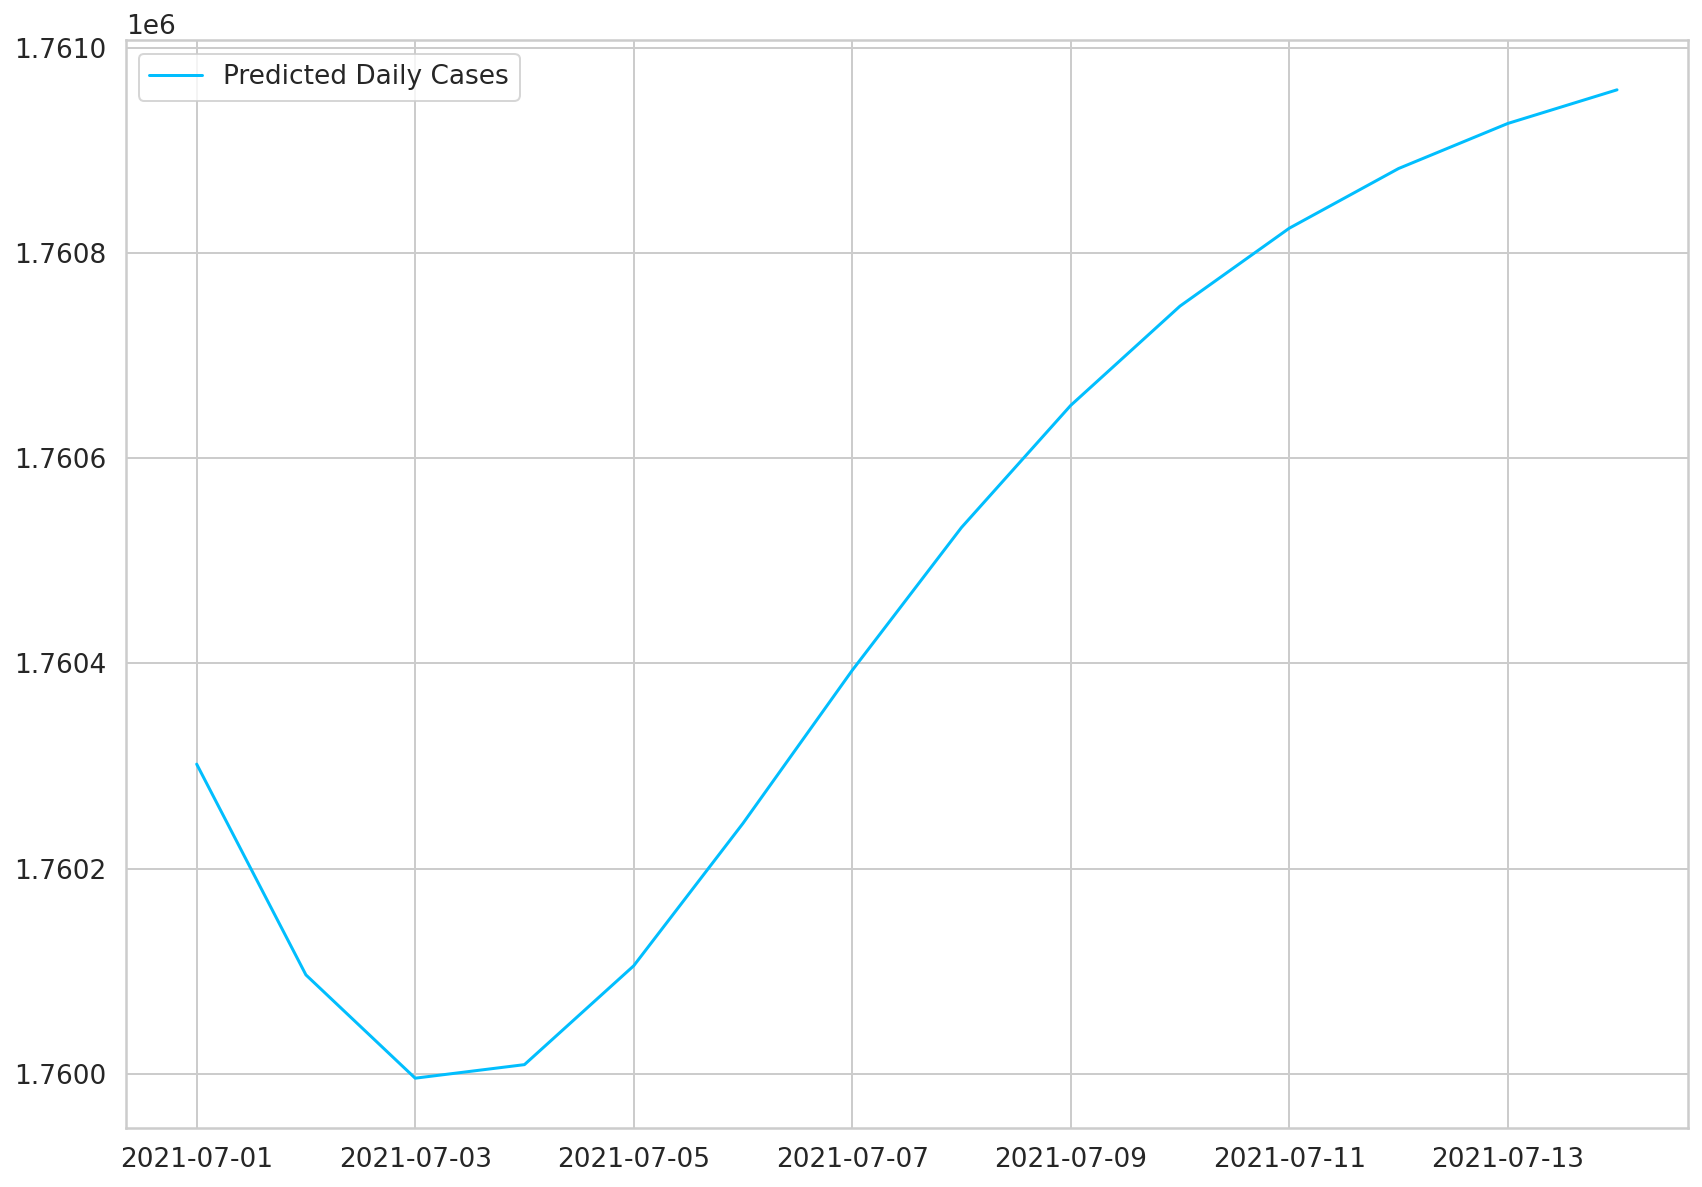

In [46]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [47]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [48]:
preds_

,0
2021-07-01,1.760302e+06
2021-07-02,1.760096e+06
2021-07-03,1.759996e+06
2021-07-04,1.760009e+06
2021-07-05,1.760105e+06
2021-07-06,1.760244e+06
2021-07-07,1.760393e+06
2021-07-08,1.760532e+06
2021-07-09,1.760652e+06
2021-07-10,1.760748e+06


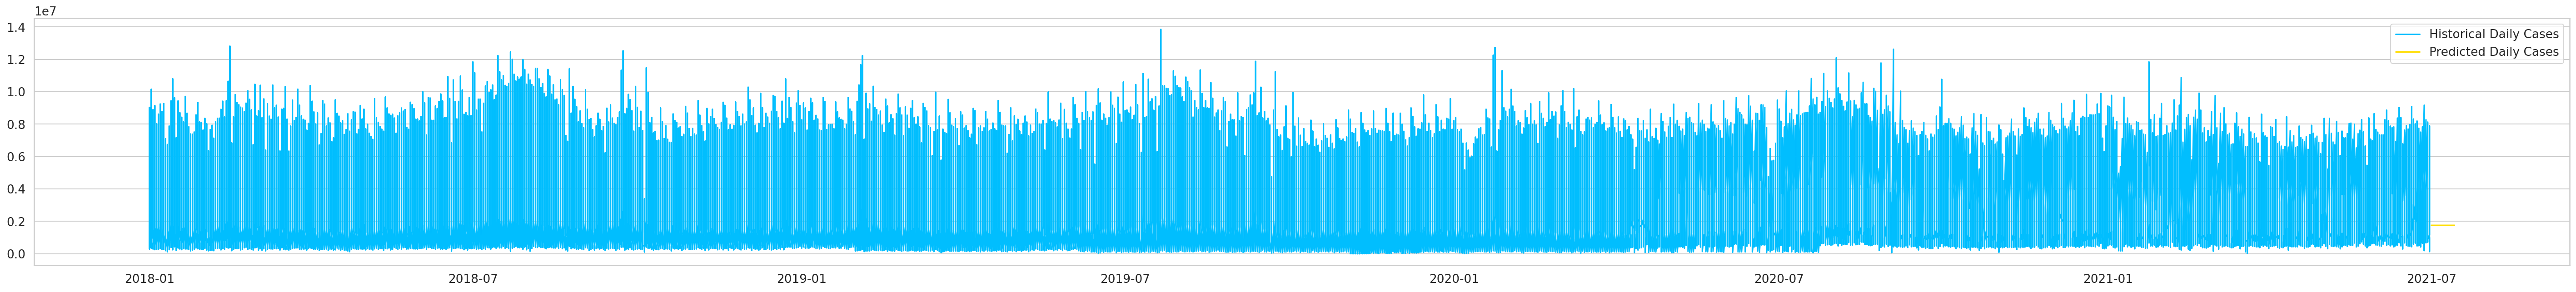

In [52]:
plt.figure(figsize=(50,5))
plt.plot(df['em_g'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.grid(axis='x')
plt.legend();

# Prophet - Additive 모델 기반 시계열 예측
* https://unfinishedgod.netlify.app/2021/04/19/python-%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8-%EC%A3%BC%EA%B0%80-%EC%98%88%EC%B8%A1-study/

In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/BigCon/0815음쓰-외국인데이터병합.csv')
df = df[['base_date', 'em_g']]
df = df.rename(columns={'base_date': 'ds', 'em_g': 'y'})
df.head()

,ds,y
0,2018-01-01,1708250
1,2018-01-01,1239600
2,2018-01-01,9357900
3,2018-01-01,1717700
4,2018-01-01,1264950


In [3]:
from fbprophet import Prophet

prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)

prophet.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [4]:
# 미래값 예측 - 일단 30일
future_data = prophet.make_future_dataframe(periods = 30, freq = 'd')
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1302,2021-07-26,2.656507e+06,24699.253775,4.961539e+06
1303,2021-07-27,2.590348e+06,39929.050758,5.154804e+06
1304,2021-07-28,2.547499e+06,44553.166471,4.997964e+06
1305,2021-07-29,2.596000e+06,175274.899575,4.922822e+06
1306,2021-07-30,2.519336e+06,40486.697812,5.034876e+06


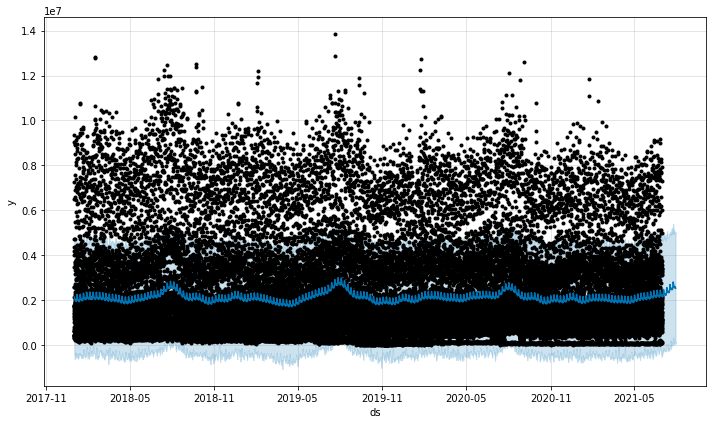

In [5]:
fig1 = prophet.plot(forecast_data)

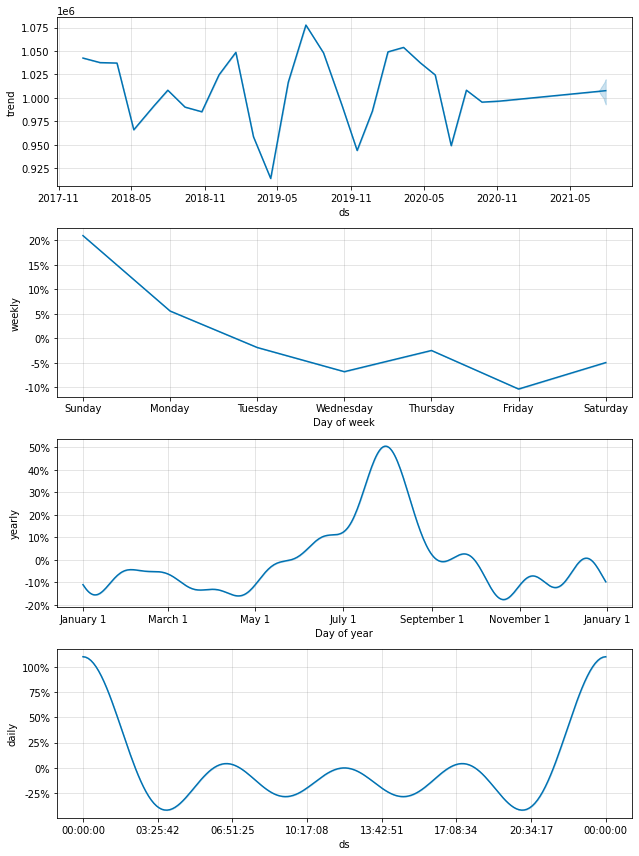

In [6]:
fig2 = prophet.plot_components(forecast_data)

In [7]:
test_df = df[-30:]

# 마지막 30일의 예측 데이터 
pred_y = forecast_data.yhat.values[-30:]

# 실제 30일의 데이터 
test_y = test_df.y.values

# 마지막 30일의 예측 데이터 최소값
pred_y_lower = forecast_data.yhat_lower.values[-30:]
# 마지막 30일의 예측 데이터 최대값
pred_y_upper = forecast_data.yhat_upper.values[-30:]

In [8]:
test_y = test_df.y.values
test_y

array([ 818000, 3127900, 1633000, 3380000, 1090000, 3565000, 1450750,
         84050, 3367800, 6004450, 1149750,  688550, 1829900, 3154850,
       1105550, 2147800,  139750, 7304500,  764450, 4963450,  926600,
       2175450, 2101200, 1441350, 1070950, 1377450,  973850, 3298100,
       3749600, 1011050])

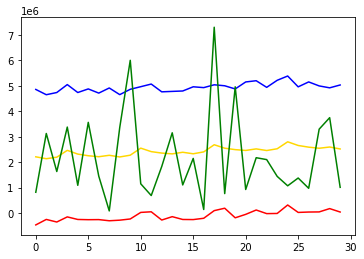

In [10]:
# 모델이 예측한 가격 그래프
import matplotlib.pyplot as plt
plt.plot(pred_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프 - 성능 향상을 위한 추가 처리 필요
plt.plot(test_y, color = 'green')

In [11]:
# RMSE
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
rmse

1697766.054140305